## The Nelder-Mead agorithm

In [1]:
#from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
from scipy.optimize import rosen
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

The Nelder-Mead algorithm is a trusted region algorithm that uses a *simplex* to search for a minimum. The algorithm prescribes rules on how to progress the simplex form one iteration to the next until it shrinks close to the optimal point upon convergence. During a step of the algorithm the highest value point of the simplex is reflected with respect to the centroid of the remaing points. Depending on the value of the newly obtianed point the simplex gets updated by replacing the high value point with a new one, or it shrinks in size. The convergence criterion is satisfied when the standard deviation of the `y` values of the simplex corners is lower than a prespecified tolerance $\epsilon$. The following is a flowchart of the algorithm.

<div>
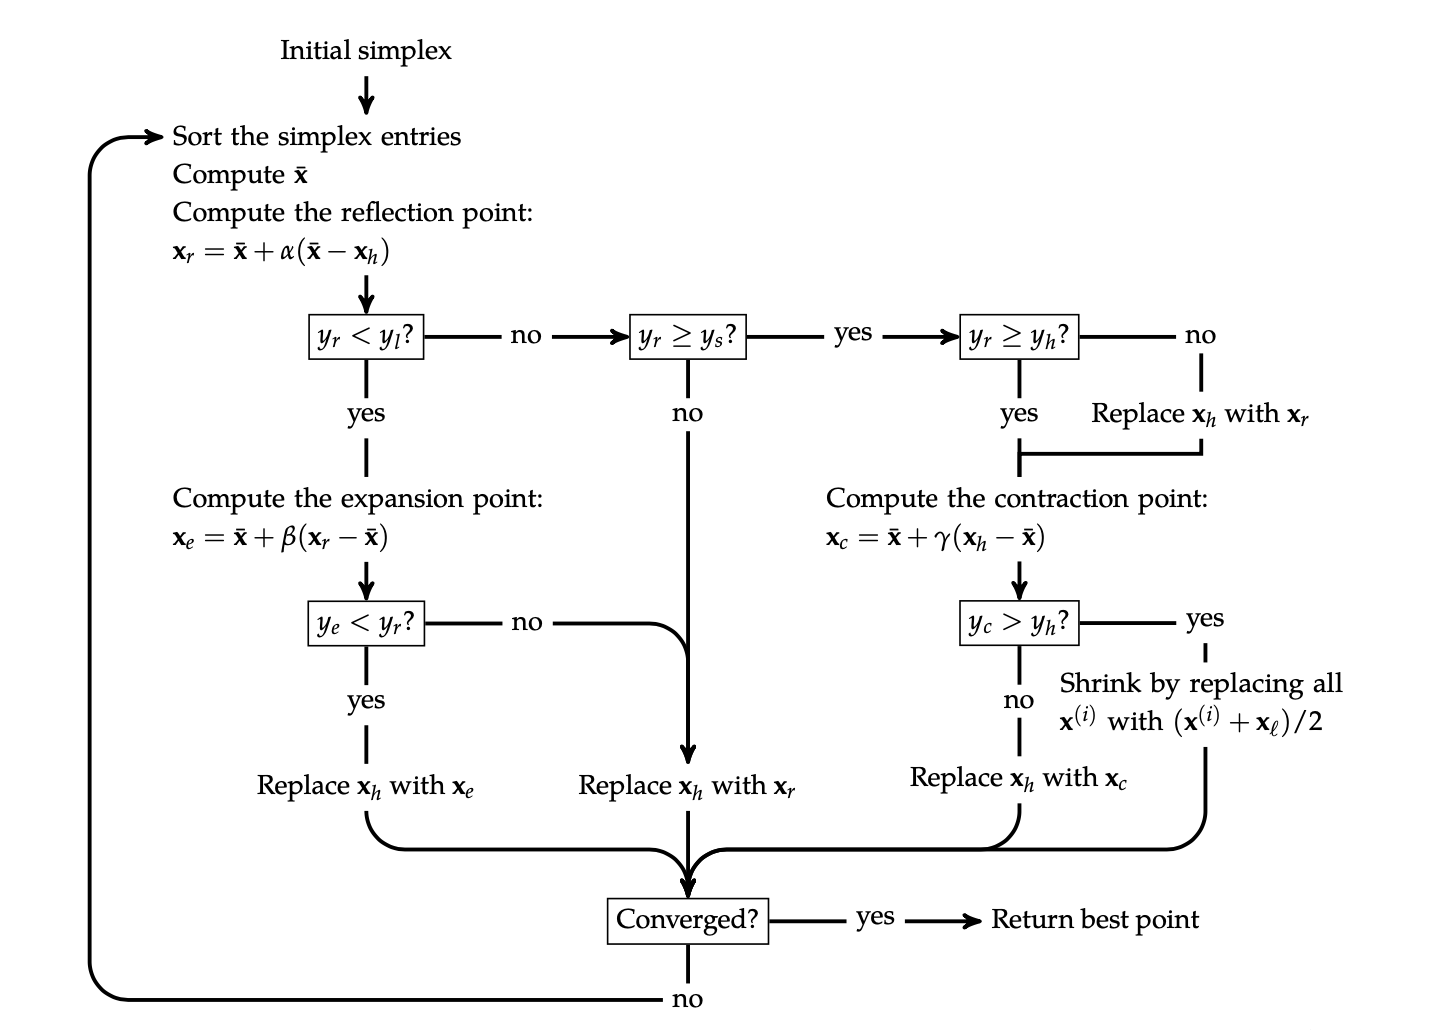
</div>

Source: Nykel J, Kochenderfer, Tim A. Wheeler *Algortihms for Optimization*, The MIT Press, 2019

In [2]:
def nelder_mead_step(of, simp, alpha=1, beta=2, gamma=0.5, sigma=0.5):

    nsimp, _ = simp.shape         
    y = of(simp.T)
    # Sort the simlpex points so they are in increasing f value
    order = np.argsort(y)
    simp = simp[order, :]
    y = y[order]
    # Calculate xbar, the centroid of the simplex minus the last point (highest f since we ordered)
    xbar = simp[:-1, :].mean(axis=0)
    # Reflection: Reflect highest point w.r.t. centroid.
    xr = xbar + alpha*(xbar - simp[-1, :])
    yr = of(xr)

    if yr<y[0]: ##expansion
        xe = xbar + beta*(xr - xbar)
        ye = of(xe)
        if ye < yr:
            new_simp = np.vstack((simp[:-1, :], xe)) #replace largest x with xe
        else:
            new_simp = np.vstack((simp[:-1, :], xr)) #replace largest x with xr
    elif yr > y[1]:
        if yr<=y[-1]:
            new_simp = np.vstack((simp[:-1, :], xr))
        xc = xbar + gamma*(simp[-1, :] - xbar)
        yc = of(xc)
        if yc < y[-1]: ## contraction
            new_simp = np.vstack((simp[:-1, :], xc)) #replace highest point by xc
        else: ## shrinkage
            new_simp = np.zeros_like(simp)
            new_simp[0, :] = simp[0, :]
            for k in range(1, nsimp):
                new_simp[k, :] = sigma*(simp[k,:] - simp[0,:])
    else:
        new_simp = np.vstack((simp[:-1, :], xr))

    return new_simp


These are the `(x,y,z)` points used for the function plot. We are using the Rosenbrock function $100(x_2-x_1^2)^2+(1-x_1)^2$ as example. The function is implemented as `rosen` in `scipy.optimize`.

In [3]:
npts = 201
x, y = np.mgrid[-2:2:npts*1j, -1:3:npts*1j]
x.shape = (npts**2)
y.shape = (npts**2)
z = rosen(np.vstack((x, y)))
x.shape = (npts, npts)
y.shape = (npts, npts)
z.shape = (npts, npts)

This is the main execution of the algorithm. `num` is the number of Nedler-Mead iterations we want to run, and  

In [4]:
def data_gen(num,fig,eps):
    # These are the three starting corners of the simplex
    x0 = np.array([1, 0])
    x1 = np.array([2, 0])
    x2 = np.array([1.5,2])
    sim_list=[]
    # We stack them 
    simp = np.vstack((x0, x1, x2))
    sim_list.append(simp)
    # We run num steps of the algorithm
    for k in range(num):
        ax1 = fig.add_subplot(frows,3,k+1)
        simp = nelder_mead_step(rosen, simp)
        sim_list.append(simp)
        # Plots
        levels = np.logspace(0, 3.2, 5)
        ax1.contour(x, y, z, levels,colors = ['k','b','g','c','y'])
        poly = plt.Polygon(simp, facecolor="none", edgecolor="r",linewidth=1.5)
        ax1.add_patch(poly)
        conv=np.std(rosen(simp.T))
        if conv < eps:
            break
    return sim_list

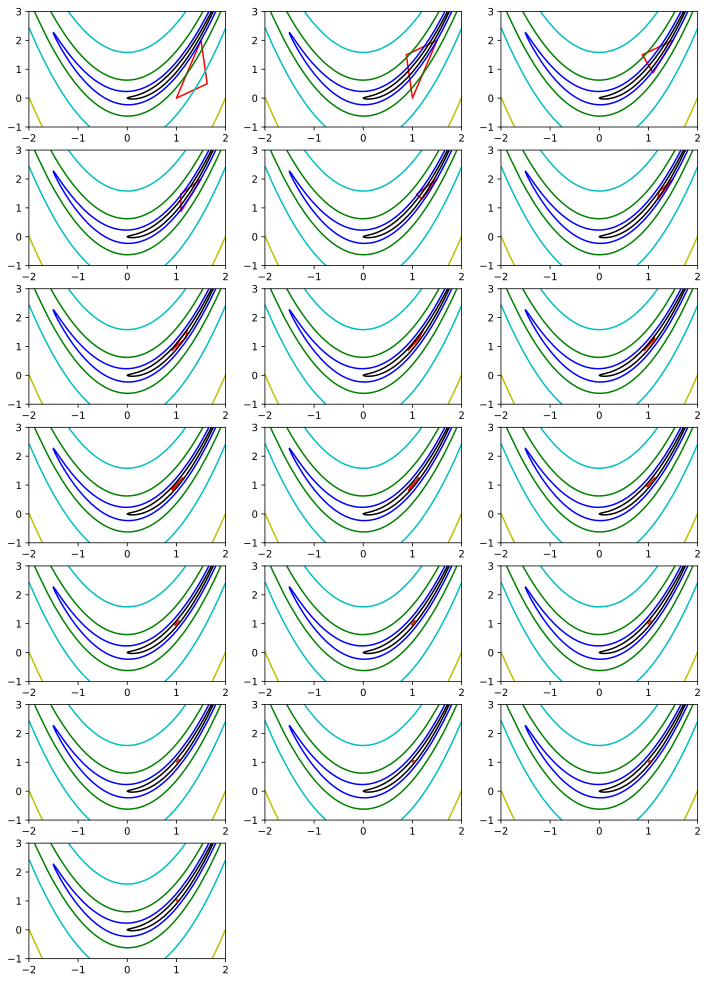

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(12, 20))
eps=0.0001
its=24
frows=int(its/3)
sim_list=data_gen(its,fig,eps)